# Visualise FFT sentiment embeddings in 2D

### Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from spreadsheet_data_handling import tweak_for_sentiment

### Split consistent with previous notebooks

In [2]:
from sklearn.model_selection import train_test_split

tweaked_df = (
    pd.read_csv('../pxtextmining/datasets/v6framework_230831.csv')
    .pipe(tweak_for_sentiment)
)

tweaked_df, test_df = train_test_split(
    tweaked_df, test_size=0.15,
    random_state=0,
    stratify=tweaked_df['Comment sentiment']
)

fft_df_trn, fft_df_val = train_test_split(
    tweaked_df, test_size=1/4, random_state=0,
    stratify=tweaked_df['Comment sentiment']
)

#For viz, use val + test splits
fft_df_valtest = pd.concat([fft_df_val, test_df], axis=0)
fft_df_valtest

fft_df_valtest[['question_type', 'answer_clean']].to_csv('pages/_example_data_valtest.csv')

### Load model and tokenizer

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

#
# Load from hub + update model's state dict
#
checkpoint = 'huawei-noah/TinyBERT_General_4L_312D'
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

#Load saved weights
model.load_state_dict(torch.load('finetuned/tinybert-sst5-fft.pickle', weights_only=True))
model.eval()


#
#Alternatively, load tokenizer + model locally
#
tokenizer = AutoTokenizer.from_pretrained('finetuned/hfcheckpoint-tokenizer')
model = AutoModelForSequenceClassification.from_pretrained('finetuned/hfcheckpoint-tinybert-sst5-fft')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### FFT to dataset

In [4]:
from datasets import Dataset
from model_utils import combine_question_answer

df = pd.read_csv('pages/_example_data_valtest.csv').dropna(axis=0)[['question_type', 'answer_clean']]

fft_dataset = Dataset.from_pandas(df)\
    .remove_columns(['__index_level_0__'])

fft_dataset = fft_dataset\
    .map(combine_question_answer, batched=True)\
    .remove_columns(['question_type', 'answer_clean',])

fft_dataset.shuffle()[:1]

Map:   0%|          | 0/2233 [00:00<?, ? examples/s]

{'q_and_a': ['Question: What could be improved? Answer: Make you sick. Food make you sick.']}

### Get embeddings

In [5]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from scipy.special import softmax

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_num_threads(4); device = 'cpu' #mimic 4-core machine

dynamic_padding_collator = DataCollatorWithPadding(tokenizer)

#Tokenize dataset
fft_tokenized = fft_dataset\
    .map(lambda batch: tokenizer(batch['q_and_a'], truncation=True, max_length=512), batched=True)\
    .remove_columns('q_and_a')

loader = DataLoader(
    fft_tokenized, batch_size=32,
    pin_memory=False if device == 'cpu' else True,
    shuffle=False, collate_fn=dynamic_padding_collator
)

#Embeddings
embeddings = []
model.to(device)
model.eval()
with torch.no_grad():
    for minibatch in loader:
        minibatch = {k: v.to(device) for k, v in minibatch.items()}

        # outputs = model.distilbert(input_ids=minibatch['input_ids'], attention_mask=minibatch['attention_mask'])
        outputs = model.bert(input_ids=minibatch['input_ids'], attention_mask=minibatch['attention_mask'])
        
        # outputs = outputs.last_hidden_state.cpu().numpy().mean(axis=1) #[B, L, emb] -> avg over L -> [B, emb]
        outputs = outputs.last_hidden_state.cpu().numpy()[:, 0, :] #[B, L, emb] -> just CLS -> [B, emb]

        embeddings.append(outputs)

embeddings = np.concatenate(embeddings, axis=0)

#Predictions
predictions = []
entropies = []
class_probs = []

model.eval()
with torch.no_grad():
    for minibatch in loader:
        minibatch = {k: v.to(device) for k, v in minibatch.items()}
        logits = model(**minibatch).logits.cpu().numpy()
        probas = softmax(logits, axis=1)

        preds = logits.argmax(axis=1)
        entr = -(probas * np.log2(probas)).sum(axis=1)
        class_p = probas[np.arange(len(logits)), preds]

        predictions.append(preds)
        entropies.append(entr)
        class_probs.append(class_p)
predictions = np.concatenate(predictions)
entropies = np.concatenate(entropies) / np.log2(5) * 100
class_probs = np.concatenate(class_probs)

Map:   0%|          | 0/2233 [00:00<?, ? examples/s]

### Interactive visualisation

In [9]:
%matplotlib widget

from umap import UMAP

from ipywidgets import interact, HTML, VBox
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import textwrap

/home/yunus/miniconda3/envs/dev/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


interactive(children=(IntSlider(value=10, description='s', max=20, min=1), FloatSlider(value=0.5, description=…

HTML(value='')

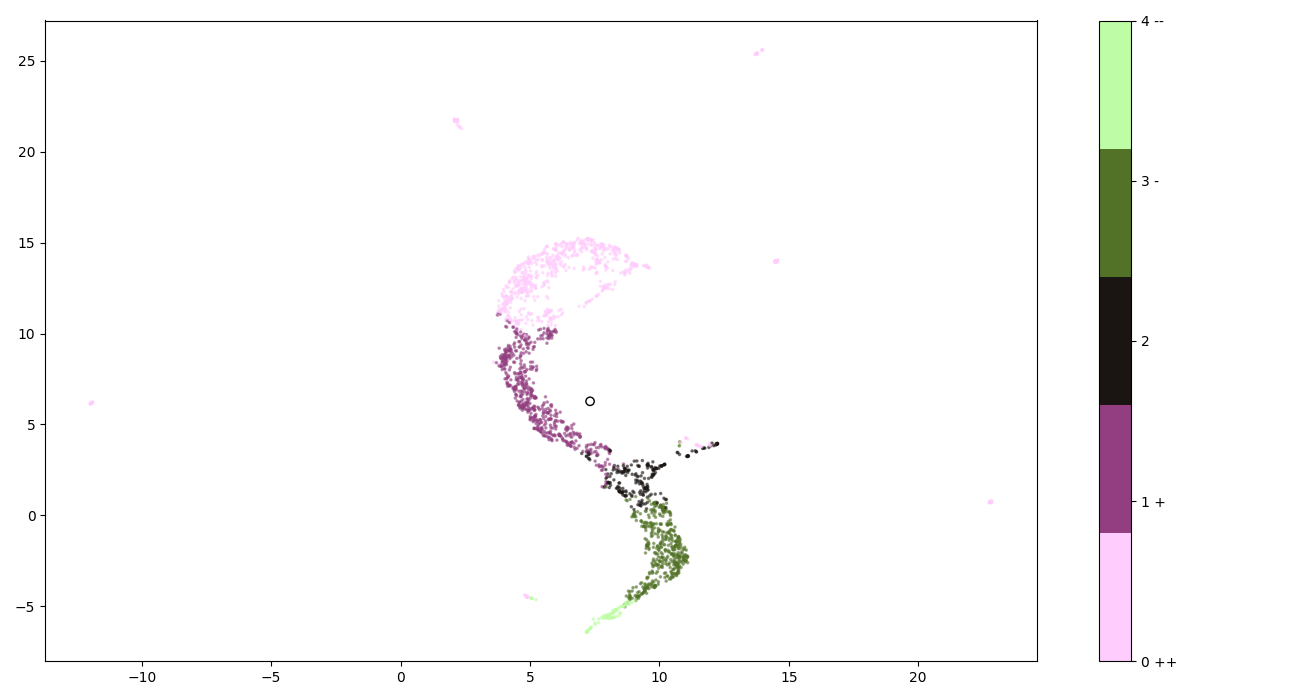

In [10]:
#Get 2D projections
proj = UMAP(n_neighbors=15, densmap=False, random_state=None).fit_transform(embeddings)
proj_x, proj_y = proj.T

#Define colourmap
cmap = ListedColormap(['tab:green', 'tab:orange', 'tab:red'])
cmap = plt.get_cmap('vanimo', 5)

#Plot figure
plt.close('all')
fig = plt.figure(figsize=(13, 7), clear=True, num=0)
scatter = plt.scatter(*proj.T, marker='.', s=10, c=predictions, cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_yticks([0, 1, 2, 3, 4]); cbar.ax.set_yticklabels(['0 ++', '1 +', '2', '3 -', '4 --'])

plt.tight_layout()

#
#ipywidgets slider
#
def size_alpha_adjust(s, alpha):
    scatter.set_alpha(alpha)
    scatter.set_sizes([s])

slider = interact(size_alpha_adjust, s=(1, 20, 1), alpha=(0.1, 1, 0.1))
# display(slider) #for interactive()

#
#ipywidgets live html table
#
live_html = HTML()

def update_live_table(event):
    if not event.inaxes:
        return
    xy = np.array([[event.xdata, event.ydata]])
    closest_index = np.argmin(np.linalg.norm(proj - xy, axis=1))
    live_html.value = df.iloc[closest_index].to_frame().to_html()
display(live_html)

fig.canvas.mpl_connect('motion_notify_event', update_live_table)

#
# Tracker
#
tracker = plt.gca().scatter(*proj.mean(axis=0), c='none', edgecolor='black')
def mouse_move_callback(event):
    ax = plt.gca()

    #if not event.inaxes
    if event.inaxes != ax:
        return
    
    xy = np.array([event.xdata, event.ydata])
    closest_ix = np.argmin(np.linalg.norm(proj - xy.reshape(1, 2), axis=1), axis=0)
    # closest_ix = np.argmin(np.where(labels==2, np.linalg.norm(proj - xy.reshape(1, 2), axis=1), np.inf), axis=0)

    txt = textwrap.fill(df.iloc[closest_ix].answer_clean, width=150)
    txt = df.iloc[closest_ix].answer_clean[:150]
    ax.set_title(txt, fontsize=9, weight='bold')
    tracker.set_offsets(proj[closest_ix])

    ax.figure.tight_layout()

fig.canvas.mpl_connect('motion_notify_event', mouse_move_callback);

### View data from a particular region

In [8]:
df.loc[(proj[:, 0] < 8.5) & (proj[:, 1] > 5)]

,question_type,answer_clean
1,nonspecific,Very professional crew dealt with me promptly ...
2,what_good,For the first time I felt I was really listene...
3,could_improve,Quick straight forward help and answer and exp...
5,nonspecific,Thay we're very attentive and quick to respond
8,could_improve,"Yes, I have to say your Patient Transport Crew..."
...,...,...
2225,could_improve,Keep doing a great job
2227,nonspecific,Prompt and efficient Very friendly Put you at ...
2228,nonspecific,The paramedics who came following my TIA were ...
2232,could_improve,Because it was very good.
